In [1]:
import pandas as pd
import numpy as np

In [2]:
dataset_path = "final_dataset/pre_processed_final.csv"
data = pd.read_csv(dataset_path)
data = data[['text', 'sentiment']]
data = data.dropna()
# text = data['text']
# lables = data['sentiment']

In [3]:
import nltk
import re

nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bharathkumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def preprocess(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Remove @mentions
    text = re.sub(r'#', '', text) # Remove hashtags
    text = re.sub(r'RT[\s]+', '', text) # Remove retweets
    text = re.sub(r'https?:\/\/\S+', '', text) # Remove hyperlinks
    text = re.sub(r'\n', '', text) # Remove newlines
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = re.sub(r'\d+', '', text) # Remove digits
    text = ' '.join([word for word in text.split() if word not in stop_words]) # remove stop words
    return text

In [5]:
processed_data = [preprocess(t) for t in data['text']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(processed_data), data['sentiment'], test_size=0.3, random_state=32)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

count_vectorizer = CountVectorizer(ngram_range=(1,1))
multinomial_NB_classifier = Pipeline([('vect', count_vectorizer), ('chi', SelectKBest(chi2, k=2890)), ('clf', MultinomialNB(alpha=1))])
model_NB = multinomial_NB_classifier.fit(data["text"], data["sentiment"])

In [7]:
y_pred = model_NB.predict(X_test[0])

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
labels = [1, 0, -1]
print("Naive Bayes classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred,labels=labels, average='macro'))
print("Recall:", recall_score(y_test, y_pred,labels=labels, average='macro'))
print("F1-score:", f1_score(y_test, y_pred,labels=labels, average='macro'))

Naive Bayes classifier
Accuracy: 0.7221830985915493
Precision: 0.7250136680195828
Recall: 0.7156678202410238
F1-score: 0.7152080018428283


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, target_names, title='Confusion matrix'):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

def plot_confusion(pred_label, y_test, labels = ["negative", "neutral", "positive"]):
    conf_mat = confusion_matrix(y_test, pred_label)
    plot_confusion_matrix(conf_mat, labels)

def get_correct_label_count(pred_label, original_label):
    return np.sum(np.array(pred_label) == np.array(original_label))

from sklearn.metrics import recall_score, f1_score

def get_recall_scores(pred_label, original_label):
    return recall_score(original_label, pred_label,labels=labels, average=None)


def get_f1_scores(pred_label, original_label):
    return f1_score(original_label, pred_label,labels=labels, average=None)

def measure_and_print_metrics(pred_label, original_label):
    print("-1: negative, 0: Neutral, 1:Positive\n")
    print(f"Accuracy:")
    print(f"correct-count:{get_correct_label_count(pred_label, original_label)},"
          f"correct_percentage: {get_correct_label_count(pred_label, original_label) / len(pred_label):.2f}% "
          f"count: {len(pred_label)}")
    print("============================================")
    print("Recall values:")
    recall_score = get_recall_scores(pred_label,original_label)
    print(recall_score)
    print(f"Recall score: {np.sum(recall_score)/3.0:.2f}")
    print("============================================")
    print("F1- scores:")
    f1_scores = get_f1_scores(pred_label, original_label)
    print(f1_scores)
    print(f"F1_measure metric: {np.sum(f1_scores)/2.0:.2f}")
    print("=============================================")
    plot_confusion(pred_label, original_label)

-1: negative, 0: Neutral, 1:Positive

Accuracy:
correct-count:6153,correct_percentage: 0.72% count: 8520
Recall values:
[0.82372003 0.56855298 0.75473045]
Recall score: 0.72
F1- scores:
[0.75857953 0.64083904 0.74620544]
F1_measure metric: 1.07


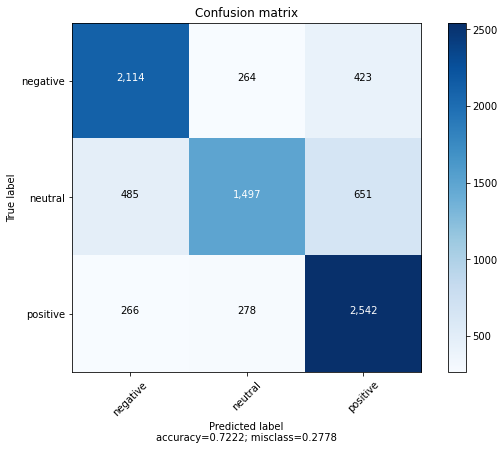

In [10]:
measure_and_print_metrics(y_pred, y_test)

In [14]:
import pickle
with open("models/multinomial_nb_model.pkl", "wb") as f:
    pickle.dump(model_NB, f)